# Pulsar star 분류 문제 

-> 별인지 펄서인지 구분하는 단층 퍼셉트론 신경망


**전체 이진분류를 직접 파이썬 코드로 구축**

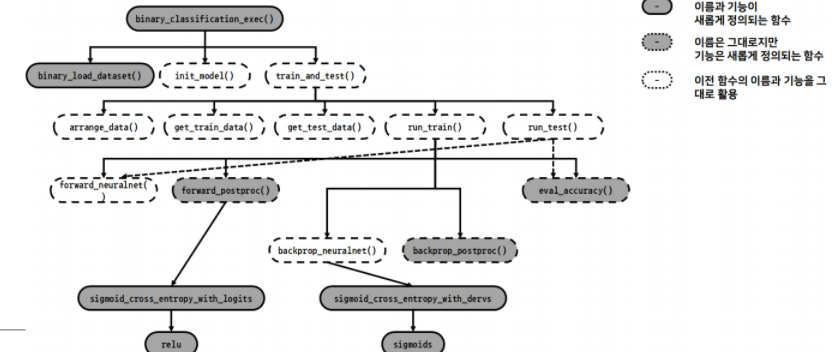

In [ ]:
import numpy as np
import csv
# 하이퍼파라미터 설정
np.random.seed(222)

RND_MEAN = 0
RND_STD=0.003

Learning_rate=0.01

In [ ]:
# 메인 함수 정의
def binary_classification_exec(epoch_count=10, mb_size=10, report=1, train_rate=0.8):
  binary_load_dataset()
  init_model()
  train_and_test(epoch_count, mb_size, report, train_rate)


In [ ]:
# 데이터 받기 -> 버퍼로 옮겨주기 -> np.array() 감싸주기
def binary_load_dataset():
  with open('/content/pulsar_stars.csv') as csvfile:
    csvreader = csv.reader(csvfile)
    next(csvreader,None)
    rows=[] # 
    for row in csvreader:
      rows.append(row)
  global data, input_cnt, output_cnt
  input_cnt=8
  output_cnt=1
  #종속 변수와 독립 변수    
  data = np.asarray(rows,dtype='float32')
  #numpy에서 산술 연산자를 효율적으로 사용하기 위해서 asarray 사용


In [ ]:
#파라미터 초기화
def init_model():
  global weight, bias, input_cnt, output_cnt
  weight = np.random.normal(RND_MEAN, RND_STD, [input_cnt, output_cnt])
  bias = np.random.normal(RND_MEAN, RND_STD, [output_cnt])

In [ ]:
def train_and_test(epoch_count, mb_size,  report, train_rate):
  step_count=arrange_data(mb_size, train_rate)
  test_x, test_y = get_test_data()

  for epoch in range(epoch_count):
    losses, accs = [],[]

    for n in range(step_count):
      train_x, train_y = get_train_data(mb_size,n)
      loss,acc = run_train(train_x,train_y)
      losses.append(loss)
      accs.append(acc)

    if report >0 and (epoch+1) % report ==0:
      acc = run_test(test_x,test_y)
      print('Epoch {} : loss = {:5.3f}, acc = {:5.3f}/ {:5.3f}'.format(epoch+1,np.mean(losses),np.mean(accs),acc))
  
  final_acc = run_test(test_x, test_y)
  print('\nFinal Test: final accuracy = {:5.4f}'.format(final_acc))
  

In [ ]:
def arrange_data(mb_size, train_rate):
  global data, shuffle_map, test_begin_idx
  shuffle_map=np.arange(data.shape[0])
  np.random.shuffle(shuffle_map)

  step_count = int(data.shape[0]*train_rate)//mb_size
  test_begin_idx = step_count * mb_size

  return step_count

In [ ]:
def get_test_data():
  global data, shuffle_map, test_begin_idx, output_cnt
  test_data = data[shuffle_map[test_begin_idx:]]
  return test_data[:,:-output_cnt], test_data[:,-output_cnt:] 
  # 가장 끝에 있는 값 전까지, 가장 끝에꺼 한 개!

In [ ]:
def get_train_data(mb_size, nth):
  global data, test_begin_idx, shuffle_map, data, output_cnt
  if nth==0: 
    # 처음에 오는 미니배치므로 epoch이 하나 돌았다.
    np.random.shuffle(shuffle_map[:test_begin_idx]) #범위까지만 돈다.
  train_data = data[shuffle_map[mb_size*nth : mb_size*(nth+1)]]
  return train_data[:, :-output_cnt], train_data[:,-output_cnt: ]

In [ ]:
def run_train(x,y):
  output, aux_nn = forward_neuralnet(x) # aux_nn은 역전파 할 때, 보조지표
  #손실값 구축
  loss, aux_pp = forward_postproc(output, y)
  accuracy = eval_accuracy(output, y)

  ###### 이까지 순전파

  G_loss = 1.0
  G_output = backprop_postproc(G_loss, aux_pp)    # 손실함수의 기울기
  backprop_neuralnet(G_output, aux_nn)

  return loss, accuracy

In [ ]:
def run_test(x, y):
  output, _ = forward_neuralnet(x) # 두 번째꺼는 필요없어서 언더바
  accuracy = eval_accuracy(output,y)
  return accuracy

In [ ]:
def forward_neuralnet(x):
  global weight, bias
  output = np.matmul(x, weight) + bias
  return output, x 
  #x는 보조지표

In [ ]:
def backprop_neuralnet(G_output, x):
  global weight,bias
  g_output_w = x.transpose()

  G_w = np.matmul(g_output_w, G_output)
  G_b = np.sum(G_output, axis=0)

  weight -= Learning_rate * G_w
  bias -= Learning_rate * G_b
  #경사하강법 

In [ ]:
def forward_postproc(output, y):
  CEE = sigmoid_cross_entropy_with_logits(y,output)
  loss = np.mean(CEE)

  return loss, [y,output,CEE]
  # 배열에는 역전파를 만들 때 그대로 사용한다.

# 손실함수에 대한 과정을 역전파 하는 단계
def backprop_postproc(G_loss, aux):
    y, output, entropy = aux
    G_loss = 1.0
    
    #평균에 관한 손실함수의 기울기 구하는 과정 -> 교차 엔트로피를 변수화하여 수행하게 되는 방식으로 수행
    g_loss_entropy = 1.0 / np.prod(entropy.shape)
    # 교차 엔트로피에 대한 편미분 과정
    g_entropy_output = sigmoid_cross_entropy_with_logits_derv(y, output)    
    
    G_entropy = g_loss_entropy * G_loss
    G_output = g_entropy_output * G_entropy
    
    return G_output

In [ ]:
#시그모이드 교차 엔트로피 함수
def relu(x):
  return np.maximum(x,0)
# relu는 입력값이 0보다 크다면 그 값을 그대로 출력하고 0보다 작으면 0을 출력
  
def sigmoid_cross_entropy_with_logits(z,x):
  return relu(x)-x*z+np.log(1+np.exp(-np.abs(x)))


def sigmoid(x):
  return np.exp(-relu(-x))/(1.0+np.exp(-np.abs(x)))

#시그모이드 교차 엔트로피의 편미분 함수
def sigmoid_cross_entropy_with_logits_derv(z,x):
  return -z+sigmoid(x)


In [ ]:
#이진 판단 문제의 정확도 계산 과정
#우선 신경망이 추정한 로짓값에 따른 시그모이드 함수를 거친 판단과 실제 정답으로 주어진 판단이 일치하는 비율을 따지기
def eval_accuracy(output, y):
    estimate = np.greater(output, 0)
    answer = np.greater(y, 0.5) #0을 기준으로 이 값보다 크면 참(1의 값 가짐), 반대로는 거짓(0의 값 가짐)
    correct = np.equal(estimate, answer) #신경망의 연산 결과와 실제 정답의 일치 여부 판단
    
    return np.mean(correct)

In [ ]:
binary_classification_exec()

Epoch 1 : loss = 1.584, acc = 0.947/ 0.975
Epoch 2 : loss = 1.343, acc = 0.955/ 0.973
Epoch 3 : loss = 1.238, acc = 0.957/ 0.973
Epoch 4 : loss = 1.455, acc = 0.955/ 0.976
Epoch 5 : loss = 1.113, acc = 0.957/ 0.921
Epoch 6 : loss = 1.142, acc = 0.958/ 0.970
Epoch 7 : loss = 1.298, acc = 0.957/ 0.974
Epoch 8 : loss = 1.236, acc = 0.958/ 0.976
Epoch 9 : loss = 1.136, acc = 0.959/ 0.956
Epoch 10 : loss = 1.244, acc = 0.958/ 0.973

Final Test: final accuracy = 0.9730


**정확도가 매우 높아 의심스러운 상황이다.**

In [ ]:
#데이터 분포 확인
import pandas as pd

read_csv = pd.read_csv('/content/pulsar_stars.csv')

print(read_csv.info())
print(read_csv['target_class'].value_counts())
#0에 매우 치우치는 것을 확인가능하다. -> 일반 별이라고 무조건 말하면 정확도는 90이다.
#그래서 약간의 이상치 데이터를 섞어주는 것이 좋다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0    Mean of the integrated profile                17898 non-null  float64
 1    Standard deviation of the integrated profile  17898 non-null  float64
 2    Excess kurtosis of the integrated profile     17898 non-null  float64
 3    Skewness of the integrated profile            17898 non-null  float64
 4    Mean of the DM-SNR curve                      17898 non-null  float64
 5    Standard deviation of the DM-SNR curve        17898 non-null  float64
 6    Excess kurtosis of the DM-SNR curve           17898 non-null  float64
 7    Skewness of the DM-SNR curve                  17898 non-null  float64
 8   target_class                                   17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB
None
0

**그래서 정밀도와 재현율의 조화평균인 f1 score 사용**

In [ ]:
# 메인 함수 정의
# adjust_ratio로 pulsar 데이터를 증폭시켜줌
def binary_classification_exec(epoch_count=10, mb_size=10, report=1, train_rate=0.75, adjust_ratio = False):
  binary_load_dataset(adjust_ratio)
  init_model()
  train_and_test(epoch_count, mb_size, report, train_rate)


In [ ]:
def binary_load_dataset(adjust_ratio):
  pulsars, stars = [],[]
  with open('/content/pulsar_stars.csv') as csvfile:
    csvreader = csv.reader(csvfile)
    next(csvreader,None)
    
    #stars와 pulsars라는 빈 객체에 데이터를 저장
    for row in csvreader:
      if row[8] == '1' : pulsars.append(row)
      else:
        stars.append(row)
        
  global data, input_cnt, output_cnt
  input_cnt, output_cnt = 8,1
  star_cnt, pulsar_cnt = len(stars), len(pulsars)
  # adjust_ratio가 참인 경우, 기존 data버퍼 보다 크기를 star_cnt 2배만큼 늘림
  if adjust_ratio:
    data = np.zeros([2*star_cnt,9])
    data[0:star_cnt, :] = np.asarray(stars, dtype="float32")
    
    # 절반은 기존 start 데이터에 나머지는 pulsar 데이터를 담아준다.
    # for와 %을 통해 pulsar 데이터의 범위를 반복해 data 버퍼에 담는다.
    for n in range(star_cnt):
      data[star_cnt+n] = np.asarray(pulsars[n % pulsar_cnt], dtype='float32')
  
  #이전 과정과 같이 똑같으 수행
  else:
    data = np.zeros([star_cnt+pulsar_cnt,9])
    data[0:star_cnt, :] = np.asarray(stars, dtype='float32')
    data[star_cnt:,:] = np.asarray(pulsars, dtype='float32')

In [ ]:
def eval_accuracy(output,y):
  est_yes = np.greater(output,0)
  ans_yes = np.greater(y, 0.5)
  est_no = np.logical_not(est_yes)
  ans_no = np.logical_not(ans_yes)
  #np.logical_not은 입력값이 참일 경우에 거짓을 출력하고 반대도 수행
  
  tp = np.sum(np.logical_and(est_yes,ans_yes))
  fp = np.sum(np.logical_and(est_yes, ans_no))
  fn = np.sum(np.logical_and(est_no, ans_no))
  tn = np.sum(np.logical_and(est_no, ans_yes))
  
  accuracy = safe_div(tp+tn,tp+fp+fn+tn)
  precision = safe_div(tp,tp+fp)
  recall = safe_div(tp,tp+fn)
  f1 = 2 * safe_div(recall*precision,recall+precision)
  return [accuracy, precision, recall, f1]

In [ ]:
def safe_div(p, q):
  #형변환
  p, q = float(p), float(q)
  if np.abs(q) < 1.0e-20: #분모가 매우 작은 값으로 0인 경우에 분모를 분자의 부호에 맞는 1 or -1로 변환
    return np.sign(p)
  return p / q

In [ ]:
def train_and_test(epoch_count, mb_size, report, train_rate):
  step_count = arrange_data(mb_size, train_rate)
  test_x, test_y = get_test_data()
  for epoch in range(epoch_count):
    losses = []
    
    for n in range(step_count):
      train_x, train_y = get_train_data(mb_size,n)
      loss, _ = run_train(train_x,train_y)
      losses.append(loss)

      
    if report > 0 and (epoch + 1) % report == 0:
      acc = run_test(test_x,test_y)
      print("epoch{}:TRAIN -LOSS = {:5.3f},\n accuracy:{:5.3f},precision:{:5.3f},recall:{:5.3f},f1:{:5.3f}".\
            format(epoch+1,np.mean(losses), acc[0],acc[1],acc[2],acc[3]))
  final_acc = run_test(test_x, test_y)
  print("\n 최종 테스트 :\n accuracy:{:5.3f},precision:{:5.3f},recall:{:5.3f},f1:{:5.3f}".\
        format(final_acc[0],final_acc[1],final_acc[2],final_acc[3]))

In [ ]:
binary_classification_exec(epoch_count=1000, mb_size = 10, report=100, train_rate=0.75, adjust_ratio=False)

epoch100:TRAIN -LOSS = 0.975,
 accuracy:0.091,precision:0.943,recall:0.073,f1:0.135
epoch200:TRAIN -LOSS = 1.268,
 accuracy:0.091,precision:0.910,recall:0.076,f1:0.141
epoch300:TRAIN -LOSS = 1.098,
 accuracy:0.091,precision:0.776,recall:0.082,f1:0.148
epoch400:TRAIN -LOSS = 0.981,
 accuracy:0.091,precision:0.981,recall:0.071,f1:0.133
epoch500:TRAIN -LOSS = 0.933,
 accuracy:0.091,precision:0.846,recall:0.082,f1:0.149
epoch600:TRAIN -LOSS = 0.858,
 accuracy:0.091,precision:0.932,recall:0.076,f1:0.140
epoch700:TRAIN -LOSS = 1.009,
 accuracy:0.091,precision:0.978,recall:0.070,f1:0.131
epoch800:TRAIN -LOSS = 1.029,
 accuracy:0.091,precision:0.869,recall:0.079,f1:0.145
epoch900:TRAIN -LOSS = 1.124,
 accuracy:0.091,precision:0.938,recall:0.067,f1:0.124
epoch1000:TRAIN -LOSS = 0.883,
 accuracy:0.091,precision:0.828,recall:0.083,f1:0.150

 최종 테스트 :
 accuracy:0.091,precision:0.828,recall:0.083,f1:0.150


In [ ]:
binary_classification_exec(epoch_count=1000, mb_size = 10, report=100, train_rate=0.75, adjust_ratio=True)

epoch100:TRAIN -LOSS = 3.340,
 accuracy:0.497,precision:0.985,recall:0.465,f1:0.632
epoch200:TRAIN -LOSS = 3.118,
 accuracy:0.497,precision:0.993,recall:0.450,f1:0.619
epoch300:TRAIN -LOSS = 3.075,
 accuracy:0.497,precision:0.869,recall:0.506,f1:0.640
epoch400:TRAIN -LOSS = 2.978,
 accuracy:0.497,precision:0.983,recall:0.472,f1:0.638
epoch500:TRAIN -LOSS = 2.941,
 accuracy:0.497,precision:0.990,recall:0.465,f1:0.633
epoch600:TRAIN -LOSS = 2.966,
 accuracy:0.497,precision:0.960,recall:0.484,f1:0.643
epoch700:TRAIN -LOSS = 2.968,
 accuracy:0.497,precision:0.977,recall:0.475,f1:0.639
epoch800:TRAIN -LOSS = 2.996,
 accuracy:0.497,precision:0.985,recall:0.471,f1:0.637
epoch900:TRAIN -LOSS = 2.834,
 accuracy:0.497,precision:0.857,recall:0.528,f1:0.654
epoch1000:TRAIN -LOSS = 2.854,
 accuracy:0.497,precision:0.914,recall:0.504,f1:0.649

 최종 테스트 :
 accuracy:0.497,precision:0.914,recall:0.504,f1:0.649


이러한 데이터 증폭 방식을 이용해 모든 지표가 더 높은 결과값을 출력하고 특히 재현율과 f1 score가 눈에 띄게 향상


하지만 데이터 증폭 방식을 무작정 사용하면 과잉적합이 생김